# Создаём свой когнитивный портрет

Привет! Сейчас мы погрузимся в мир **Science Art**, где наука -- а именно **искусственный интеллект** -- поможет нам создавать произведения искусства! А именно, мы познакомимся с техникой [когнитивного портрета](http://bit.do/peopleblending).

<img src="https://soshnikov.com/images/art/PhoBoGuy.png" width="30%"/>

В этой технике мы используем **нейросеть** для выделения ключевых точек лица на серии фотографий, с последующим поворотом и масштабированием фотографий таким образом, чтобы глаза и рот на всех снимках совпадали. Совмещая такие снимки, мы получаем интересный визуальный эффект. 



### Используем Python и Jupyter Notebook

Для создания портрета мы будем использовать язык программирования Python. Не волнуйтесь, чтобы получить портрет, на первых этапах вам не придётся писать свой код, а только выполнять существующий! Однако если вы умеете программировать (или научитесь это делать), то сможете получать намного более интересные визуальные эффекты! Научиться языку программирования Python можно с помощью [этого курса](http://pythontutor.ru), или курса [PyCourse](http://github.com/shwars/pycourse).

### Установка необходимых библиотек

Многие сложные операции в языке Python делаются с помощью специальных **библиотек**, т.е. написанных кем-то заранее программ. Для проведения манипуляций с изображениями нам необходима библиотека **OpenCV**, для работы с нейросетью - библиотека **dlib**. В начале работы нам необходимо установить эти библиотеки (с помошью команд `pip`) и **импортировать** их, чтобы Python в дальнейшем видел все необходимые функции. 

Следующая ячейка с командами может работать довольно долго, потому что она скачивает и устанавливает библиотеки. Дождитесь результата её выполнения! Если вы увидите предупредительное сообщение *WARNING* -- не переживайте, это нормально.

> **ВНИМАНИЕ:** Если вы используете [Google Colab](http://colab.research.google.com) для выполнения ноутбуков, то ячейку с установкой библиотек лучше пропустить. Все необходимые библиотеки уже установлены заранее.

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python dlib mPyPl

> **ВНИМАНИЕ**: Для экспериментов нам потребуется несколько изображений. Если Вы используете репозитарий GitHub - они уже есть в директории `images`. Если Вы используете **Google Colab** - выполните ячейку ниже, чтобы загрузить изображения.

In [3]:
!wget http://www.soshnikov.com/permanent/data/dsh-images.zip
!unzip dsh-images.zip

--15:33:53--  http://www.soshnikov.com/permanent/data/dsh-images.zip
           => `dsh-images.zip'
Resolving www.soshnikov.com... 79.137.227.122
Connecting to www.soshnikov.com|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3�292�713 (3.1M) [application/zip]

    0K .......... .......... .......... .......... ..........  1%    2.00 MB/s
   50K .......... .......... .......... .......... ..........  3%    5.36 MB/s
  100K .......... .......... .......... .......... ..........  4%    2.60 MB/s
  150K .......... .......... .......... .......... ..........  6%    4.83 MB/s
  200K .......... .......... .......... .......... ..........  7%    7.14 MB/s
  250K .......... .......... .......... .......... ..........  9%    7.42 MB/s
  300K .......... .......... .......... .......... .......... 10%    7.20 MB/s
  350K .......... .......... .......... .......... .......... 12%    7.82 MB/s
  400K .......... .......... .......... .......... .......... 13% 

^C


In [1]:
import os, requests, glob
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import mPyPl as mp

Мы также будем использовать библиотеку [mPyPl](http://soshnikov.com/mPyPl/), которая может оперировать именованными конвейерами. Ознакомьтесь [с тьюториалом](http://soshnikov.com/mPyPl/tutorial/index.html) по библиотеке. Вот пример её использования:

In [7]:
(range(13)
| mp.as_field('n')
| mp.unfold('fib_pair',lambda x: (x[1],x[0]+x[1]), (1,1))
| mp.apply('fib_pair','fib',lambda x: x[0])
| mp.apply('fib','fib_sq',lambda x: x*x)
| mp.select_fields(['n','fib_sq'])
| mp.as_list)

[{'n': 0, 'fib_sq': 1},
 {'n': 1, 'fib_sq': 1},
 {'n': 2, 'fib_sq': 4},
 {'n': 3, 'fib_sq': 9},
 {'n': 4, 'fib_sq': 25},
 {'n': 5, 'fib_sq': 64},
 {'n': 6, 'fib_sq': 169},
 {'n': 7, 'fib_sq': 441},
 {'n': 8, 'fib_sq': 1156},
 {'n': 9, 'fib_sq': 3025},
 {'n': 10, 'fib_sq': 7921},
 {'n': 11, 'fib_sq': 20736},
 {'n': 12, 'fib_sq': 54289}]

## Обнаруживаем лица на фотографии

Для начала, нам нужно научиться находить на фотографии лица. Для этого мы используем встроенные возможности `dlib` - **face detector**. Загрузим изображение, и попробуем найти на нём лица:

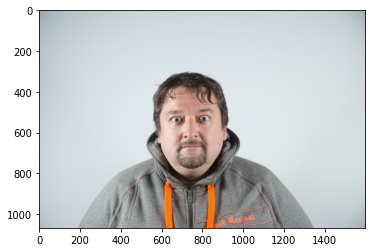

In [11]:
def load_image(fn):
  img = cv2.imread(fn)
  return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

sample="images/1-30.jpg"

img = load_image(sample)
plt.imshow(img)

rectangles[[(577, 439) (886, 749)]]


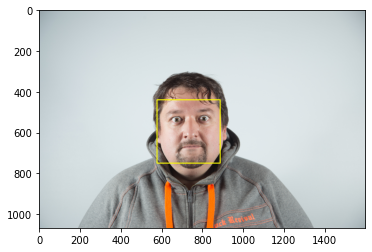

In [12]:
detector = dlib.get_frontal_face_detector()
faces = detector(img)
print(faces)

def plot_rect(img,rects=[]):
  i = img.copy()
  for r in rects:
    cv2.rectangle(i,(r.left(),r.top()),(r.right(),r.bottom()), (255,255,0), 3)
  plt.imshow(i)
  plt.show()

plot_rect(img,faces)

### Извлекаем опорные точки лица

Для извлечения опорных точек лица мы будем использовать специально обученную модель обнаружения опорных точкек. Для начала, нам нужно будет загрузить веса модели, чтобы потом использовать её встроенными средствами `dlib`:

In [9]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!7za x shape_predictor_68_face_landmarks.dat.bz2

--16:14:53--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
           => `shape_predictor_68_face_landmarks.dat.bz2'
Resolving dlib.net... 107.180.26.78
Connecting to dlib.net|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64�040�097 (61M)

    0K .......... .......... .......... .......... ..........  0%   78.82 MB/s
   50K .......... .......... .......... .......... ..........  0%  371.93 KB/s
  100K .......... .......... .......... .......... ..........  0%  370.14 KB/s
  150K .......... .......... .......... .......... ..........  0%   34.28 MB/s
  200K .......... .......... .......... .......... ..........  0%  371.02 KB/s
  250K .......... .......... .......... .......... ..........  0%   46.03 MB/s
  300K .......... .......... .......... .......... ..........  0%   43.97 MB/s
  350K .......... .......... .......... .......... ..........  0%  373.52 KB/s
  400K .......... .......... .......... .......... ..........  0%   


7-Zip (A) 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18

Processing archive: shape_predictor_68_face_landmarks.dat.bz2

Extracting  shape_predictor_68_face_landmarks.dat

Everything is Ok

Size:       99693937
Compressed: 64040097


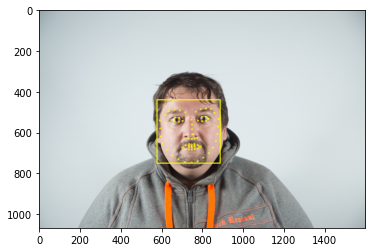

In [13]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
landmarks = predictor(img,faces[0])

def plot_dots(img,rects,dots):
  i = img.copy()
  for r in rects:
    cv2.rectangle(i,(r.left(),r.top()),(r.right(),r.bottom()), (255,255,0), 3)
  for t in range(68):
    cv2.circle(i,(dots.part(t).x,dots.part(t).y),3,(255,255,0),2)
  plt.imshow(i)
  plt.show()

plot_dots(img,faces,landmarks)

### Загружаем свои изображения

Для экспериментов нам нужны портретные изображения. Чтобы нарисовать свой портрет, вам потребуется загрузить в директорую `images` несколько (от 5 до 15, но не больше 20) своих фотографий. Для удобства в этой директории уже находятся пара фотографий - удалите их, если вы не хотите, чтобы они тоже участвовали в генерации портрета. Но можете и оставить :)

Способ загрузки изображений будет зависеть от того, какую среду для работы вы используете - попробуйте разобраться, как это сделать. Обычно пользовательский интерфейс достаточно интуитивен :)


### Использование телеграм-бота UploadGram

Одним из простых способов загрузить фотографии с телефона - это использовать телеграм-бота [Uploadgram](https://t.me/uploadgrammebot). Вы можете посылать этому боту фотографии, и он будет присылать вам в ответ ссылки на эти фотографии.

1. Добавьте на телефоне бота **@uploadgrammebot** в телеграм.
1. Пошлите ему несколько (15-20) фотографий с телефона. Посылайте их в режиме фотографий,а не файлов, чтобы заодно немного уменьшить качество, и избежать проблем с форматом изображений.
1. Откройте [Telegram Web](http://web.telegram.org) в соседнем окне браузера на компьютере.
1. Скопируйте все ссылки из диалога с ботом в список в ячейке с кодом ниже.
1. Запустите ячейку, и все изображения будут автоматически загружены в папку `images`

In [4]:
links = ['https://dl.uploadgram.me/62e24e1c8e819h','https://dl.uploadgram.me/62e24c5b28e70h','https://dl.uploadgram.me/62e24c5a861e6h']

import requests,shutil,os
for i,x in enumerate(links):
    r = requests.get(f"{x}?raw",stream=True)
    if r.status_code==200:
      with open(os.path.join('images',f"{i}.jpg"),'wb') as f:
        shutil.copyfileobj(r.raw,f)
    else:
      print(f"Error downloading from {x}, code={r.status_code}")

### Обработка фотографий

Теперь мы пройдёмся по всем изображениям в нашей директории и извлечём из них опорные точки. Если на фотографии найдено несколько лиц - будем брать первое из них. Если лиц не найдено - будем эту фотографию игнорировать.

> Вы можете усовершенствовать код, рассматривая все лица на фотографии, или же выбирая самое большое по размерам лицо.

In [22]:
images = (
  mp.get_files('images')
| mp.as_field('fname')
| mp.apply('fname','img',load_image)
| mp.apply('img','rect',detector)
| mp.core.filter('rect', (lambda x: len(x)>0))
| mp.apply(['img','rect'], 'points', lambda x: predictor(x[0],x[1][0]))
| mp.as_list)

images | mp.select_field('points') | mp.take(1) | mp.as_list

Посмотрим на несколько загруженных нами изображений:

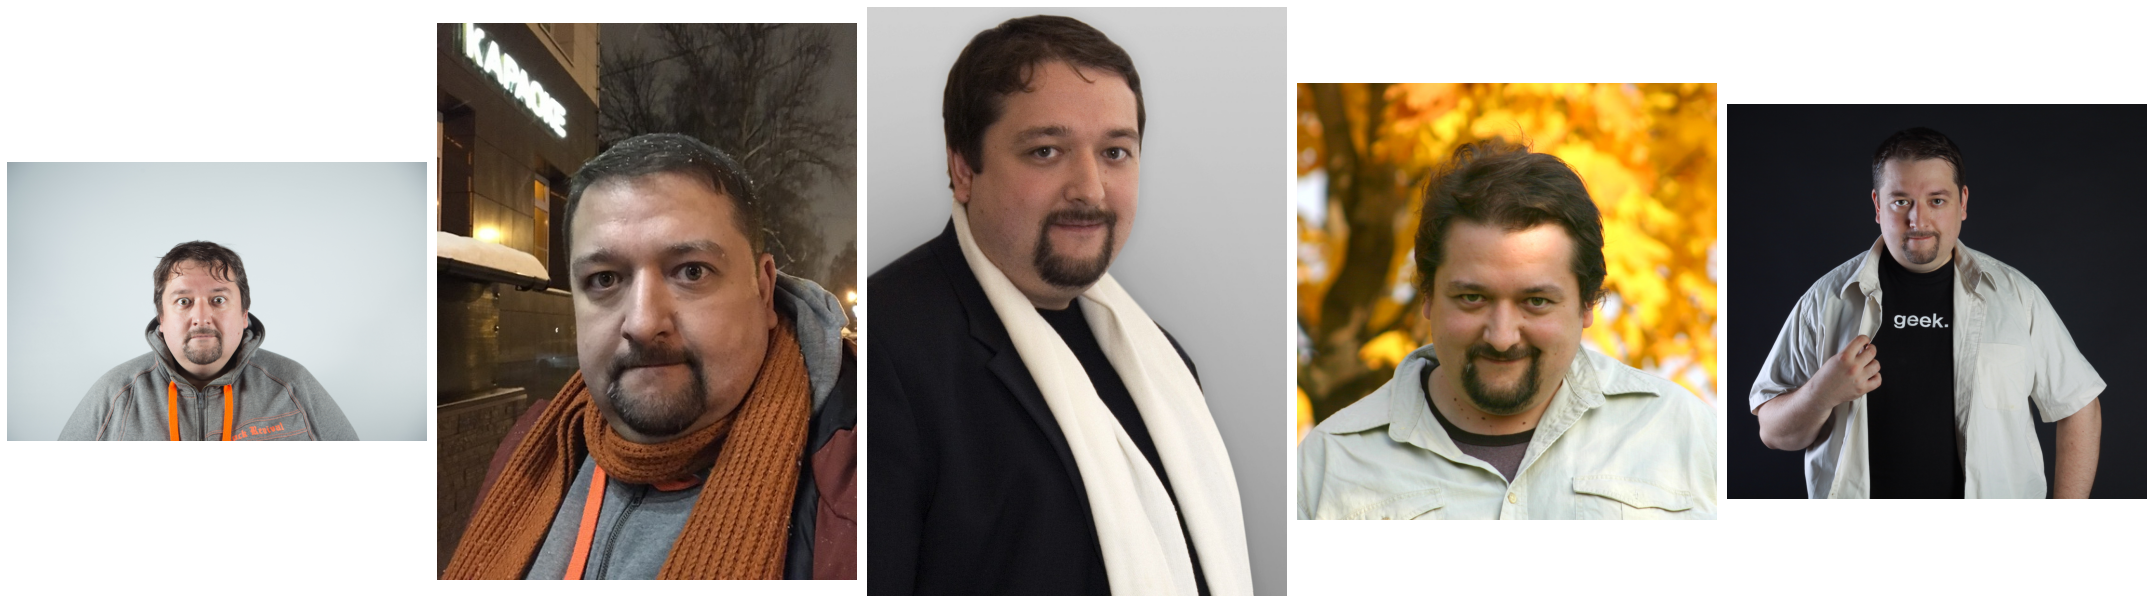

In [25]:
@mp.Pipe
def display_images(l):
    l = list(l)
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

images | mp.select_field('img') | mp.take(5) | display_images

## Аффинные преобразования

Чтобы выровнять все изображения по глазам, нам необходимо повернуть и масштабировать их. Для этого мы используем математическое понятие [**аффинного преобразования**](https://ru.wikipedia.org/wiki/Affine_transformation). Это сложное понятие, но вам не обязательно его детально понимать - главное, что мы можем применить небольшую математическую магию и совместить три точки исходного изображения (будем брать координаты двух глаз и середины рта) с заданными нами точками.

Будем ориентироваться на размер финального изображения $300\times300$ точек, тогда для координат глаз выберем точки $(130,120)$ и $(170,120)$. 

Магическая функция для выравнивания всех изображений будет иметь вид:

In [28]:
target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,lmarks):
    lefteye = ((lmarks.part(37).x+lmarks.part(40).x)/2,(lmarks.part(37).y+lmarks.part(40).y)/2)
    riteeye = ((lmarks.part(43).x+lmarks.part(46).x)/2,(lmarks.part(43).y+lmarks.part(46).y)/2)
    mouth = (lmarks.part(67).x,lmarks.part(67).y)
    tr = cv2.getAffineTransform(np.float32([lefteye,riteeye,mouth]), target_triangle)                               
    return cv2.warpAffine(img,tr,(size,size))

Выровняем с её помощью все фотографии:

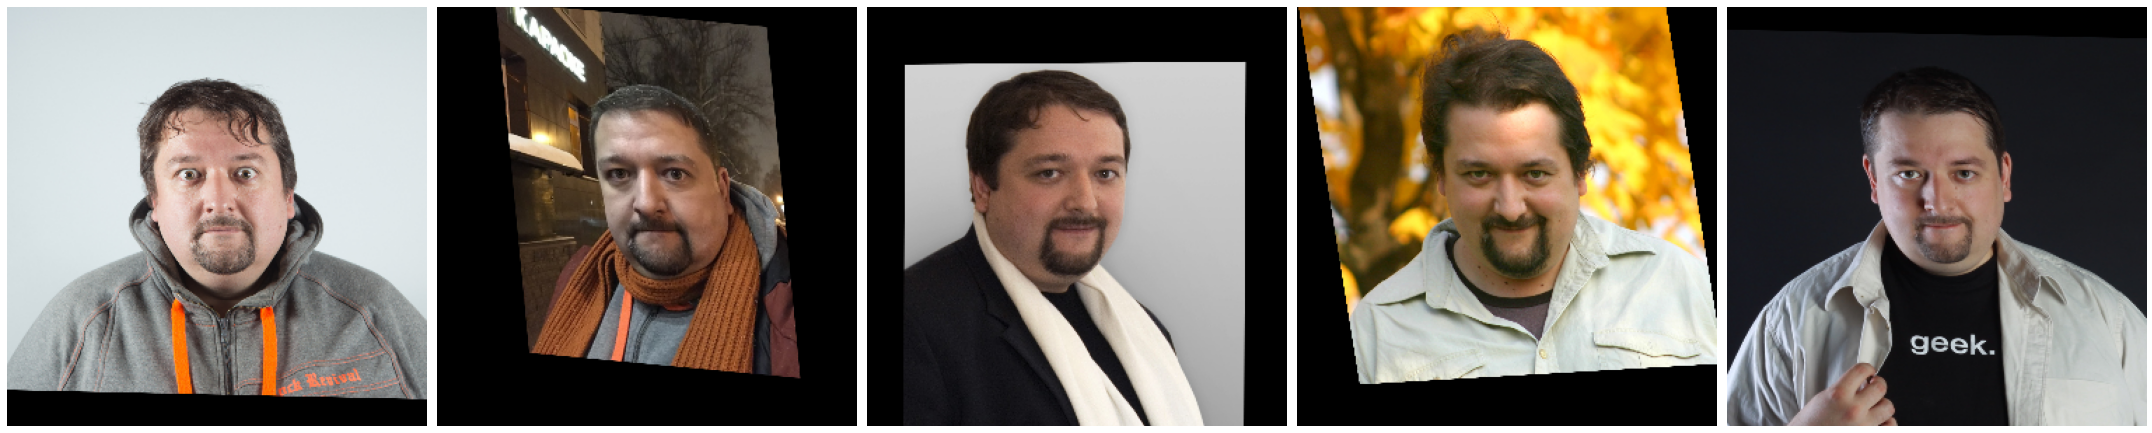

In [30]:
img_aligned = (
    images 
    | mp.apply(['img','points'],'trans',lambda x: affine_transform(*x))
    | mp.as_list)  

img_aligned | mp.take(5) | mp.select_field('trans') | display_images

## Смешивание изображений

Для получения результата нам осталось смешать эти изображения. Это несложная задача, но мы используем очень мощную функцию усреднения, которая позволит нам в дальнейшем присваивать разные веса отдельным изображениям.


In [34]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)/255.0
    return res

А теперь смешиваем все фотографии сразу, чтобы получить наш усредненный портрет!

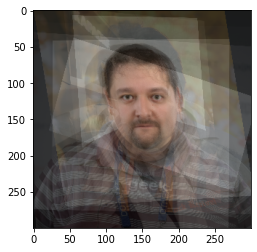

In [38]:
res = (
    img_aligned | mp.select_field('trans') | mp.as_list | mp.pexec(merge)
)
plt.imshow(res)

Мы можем сразу сгенерировать несколько изображений, смешивая картинки со случайными весами, чтобы потом выбрать из них лучший:

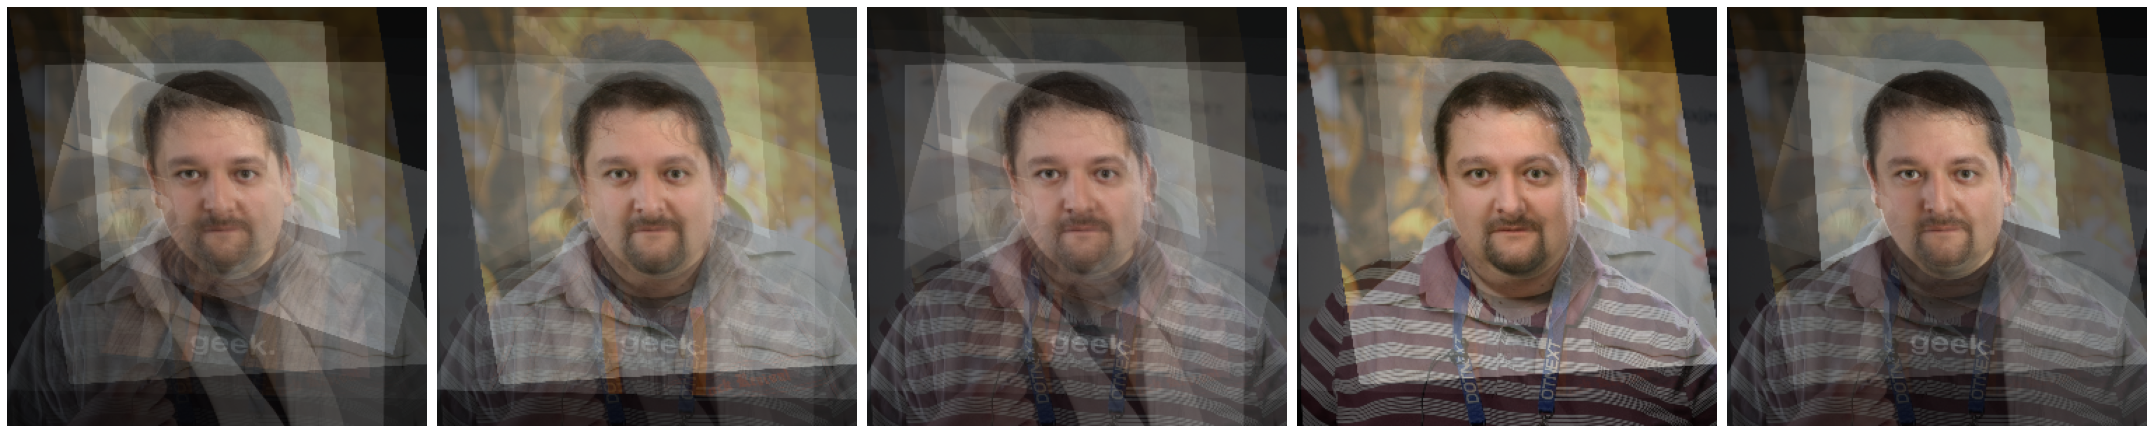

In [40]:
images = img_aligned | mp.select_field('trans') | mp.as_list
(mp.infinite()
| mp.apply(None,'rnd',lambda _ : np.random.random(len(images)))
| mp.apply('rnd','res',lambda x: merge(images,x))
| mp.select_field('res')
| mp.take(5)
| display_images)

А теперь запишем результат на диск:

In [43]:
(mp.infinite()
| mp.fenumerate('n')
| mp.apply(None,'rnd',lambda _ : np.random.random(len(images)))
| mp.apply('rnd','res',lambda x: merge(images,x))
| mp.take(5)
| mp.iter(['n','res'],lambda x: cv2.imwrite(f'result_{x[0]}.jpg',x[1]))
| mp.execute
)


Не останавливайтесь на достигнутом, творите и будьте счастливы!

## Учитесь программировать и продолжайте эксперименты!

Ура! Мы с вами научились создавать простейшие когнитивные портреты, накладывая фотографии для достижения интересного художественного эффекта! Вы можете поэкспериментировать с разными наборами фотографий, чтобы получить разные эффекты:

* Используйте фотографии одного человека разного возраста, чтобы получить эффект "омоложения"
* Комбинируйте фотографии разных людей (5 фотографий одного человека и 5 другого), чтобы смешать их вместе!
* Попробуйте смешать много фотографий разных людей

Смешивание фотографий - это лишь один приём, который можно использовать, получив координаты опорных точек лица. Вы можете делать и другие, например, поэкспериментируйте с расположением точек лица по какому-нибудь правилу, например, по окружности. Изучив возможности Python и библиотеки OpenCV по обработке изображений, вы сможете разнообразить свой творческий инструментарий, и получать действительно интересные эффекты.

В качестве самостоятельного упражнения, попробуйте получить изображение, похожее на это:

![](https://soshnikov.com/images/art/Age2.jpg)

Посмотрите также на [видео взросления](https://www.youtube.com/watch?v=ZcGrFB9idiY), полученное с помощью аналогичной техники.